In [1]:
# Code source: Brian McFee
# License: ISC

from __future__ import print_function

import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.style as ms

ms.use('seaborn-muted')
%matplotlib inline

import sklearn.cluster

import librosa
import librosa.display

In [2]:
file_path = "../data/songData/genres/blues/blues.00000.wav"
y, sr = librosa.load(file_path)

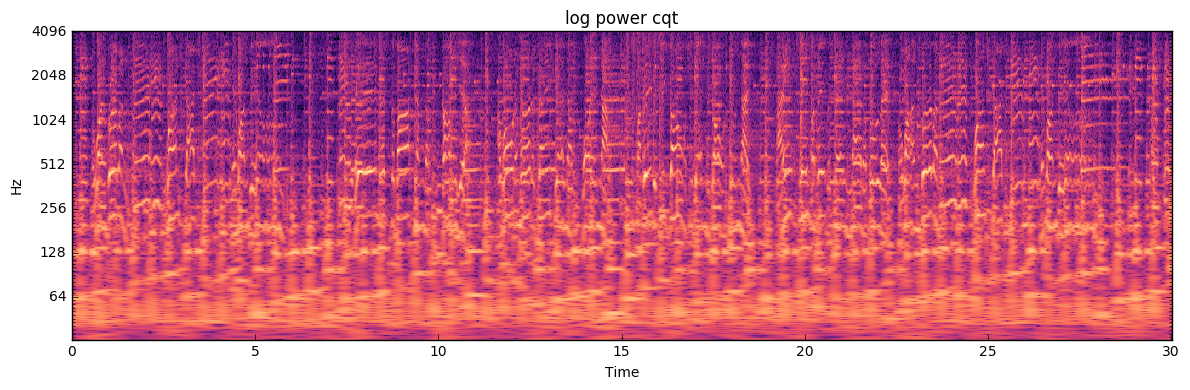

In [3]:
BINS_PER_OCTAVE = 12 * 3
N_OCTAVE = 7

C = librosa.amplitude_to_db(librosa.cqt(y=y, sr=sr,
                                        bins_per_octave=BINS_PER_OCTAVE,
                                        n_bins=N_OCTAVE * BINS_PER_OCTAVE),
                           ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(C, y_axis='cqt_hz', sr=sr,
                        bins_per_octave=BINS_PER_OCTAVE,
                        x_axis='time')
plt.title('log power cqt')
plt.tight_layout()

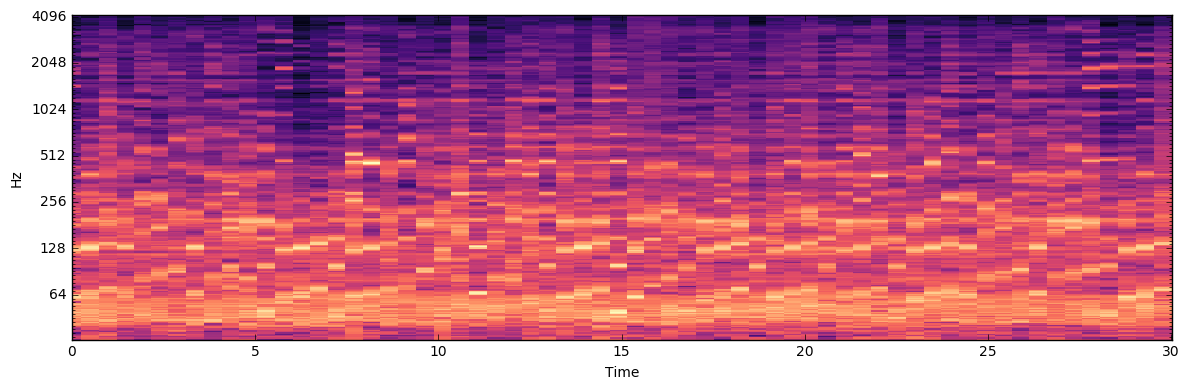

In [4]:
tempo, beats = librosa.beat.beat_track(y=y, sr=sr, trim=False)
Csync = librosa.util.sync(C, beats, aggregate=np.median)

beat_times = librosa.frames_to_time(librosa.util.fix_frames(beats,
                                                           x_min=0,
                                                           x_max=C.shape[1]),
                                   sr=sr)

plt.figure(figsize=(12, 4))
librosa.display.specshow(Csync, bins_per_octave=12*3,
                        y_axis='cqt_hz', x_axis='time',
                        x_coords=beat_times)
plt.tight_layout()

In [5]:
R = librosa.segment.recurrence_matrix(Csync, width=3, mode='affinity', sym=True)
df = librosa.segment.timelag_filter(scipy.ndimage.median_filter)
Rf = df(R, size=(1, 7))

In [6]:
mfcc = librosa.feature.mfcc(y=y, sr=sr)
Msync = librosa.util.sync(mfcc, beats)

path_distance = np.sum(np.diff(Msync, axis=1)**2, axis=0)
sigma = np.median(path_distance)
path_sim = np.exp(-path_distance / sigma)

R_path = np.diag(path_sim, k=1) + np.diag(path_sim, k=-1)

In [7]:
deg_path =np.sum(R_path, axis=1)
deg_rec = np.sum(Rf, axis=1)

mu = deg_path.dot(deg_path + deg_rec) / np.sum((deg_path + deg_rec)**2)

A = mu * Rf + (1 - mu) * R_path

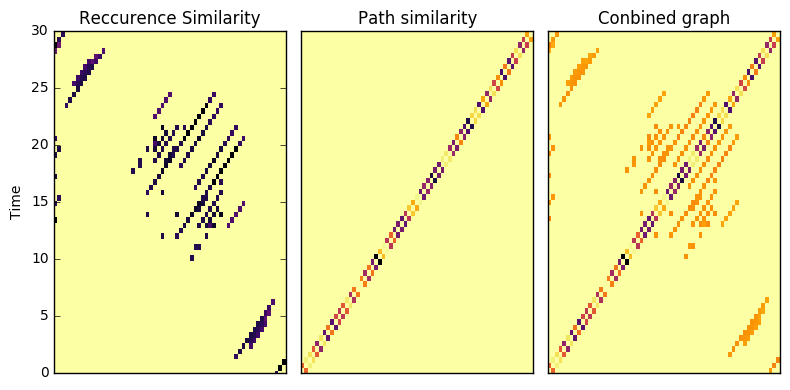

In [8]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
librosa.display.specshow(Rf, cmap='inferno_r', y_axis='time', y_coords=beat_times)
plt.title('Reccurence Similarity')

plt.subplot(1, 3, 2)
librosa.display.specshow(R_path, cmap='inferno_r')
plt.title('Path similarity')

plt.subplot(1, 3, 3)
librosa.display.specshow(A, cmap='inferno_r')
plt.title('Conbined graph')

plt.tight_layout()

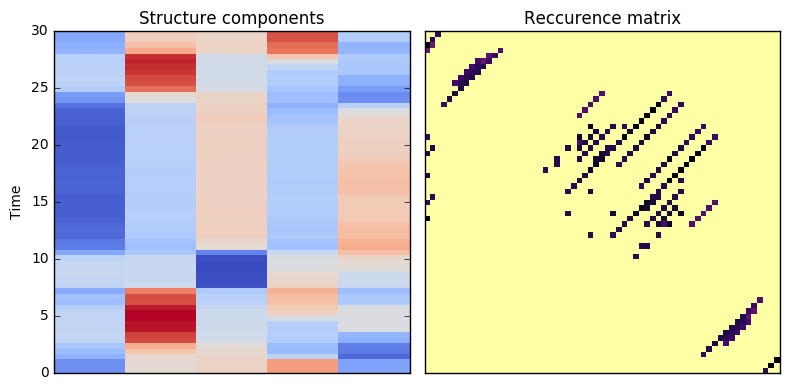

In [10]:
L = scipy.sparse.csgraph.laplacian(A, normed=True)

evals, evecs = scipy.linalg.eigh(L)

evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))
Cnorm = np.cumsum(evecs**2, axis=1)**0.5

k =5
X = evecs[:, :k] / Cnorm[:, k-1:k]

plt.figure(figsize=(8,4))

plt.subplot(1, 2, 2)
librosa.display.specshow(Rf, cmap='inferno_r')
plt.title('Reccurence matrix')

plt.subplot(1, 2, 1)
librosa.display.specshow(X,
                        y_axis='time',
                        y_coords=beat_times)
plt.title('Structure components')

plt.tight_layout()